# Table of contents

* [Loading packages](#packages)
* [Exploring the meta data](#eda)
    * [Missing values](#missing_vals)
    * [Understanding patients](#patients)
    * [Image features](#image_features)
    * [Inspecting target features](#target_features)
    * [Machine Ids](#machine_ids)
* [Exploring the images](#images)
    * [Inspecting dicom files](#dicom)
    * [Pixelarray distributions](#raw_values)
    * [Background values and image sizes](#mid_dependence)
    * [Exploring dicom images of machine 49](#mid_49)
    * [Exploring images showing cancer](#cancer)
* [Conclusion](#conclusion)

In [1]:
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: pydicom
    Found existing installation: pydicom 2.3.0
    Uninstalling pydicom-2.3.0:
      Successfully uninstalled pydicom-2.3.0


# Loading packages <a class="anchor" id="packages"></a>

In [2]:
import pandas as pd
import numpy as np

import pydicom
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_color_codes('bright')
import plotly.express as px

from PIL import Image

from scipy.stats import mode, skew

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Exploring at the meta data <a class="anchor" id="eda"></a>

In [3]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [4]:
train.shape

(54706, 14)

Ok, 54706 rows and 14 columns. Do we have missing values?

In [5]:
test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [6]:
test.shape

(4, 9)

Aha! There are a lot of columns in train that are not present in test. Some of them are related to the target feature **cancer** and it's obvious that they are not given (biopsy, invasive, BIRADS and difficult_negative_case). But what makes me wonder is that the density feature is also not given in test... 

## Missing values <a class="anchor" id="missing_vals"></a>

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

Ok, we do have missing values for the age, BIRADS and density. 

## Understanding patients <a class="anchor" id="patients"></a>

How many patients do we have?

In [8]:
train.patient_id.nunique()

11913

How old are the patients?

In [9]:
train.groupby('patient_id').age.nunique().unique()

array([1, 0])

Ok, that's good! We only have one age value per patient or none at all. 

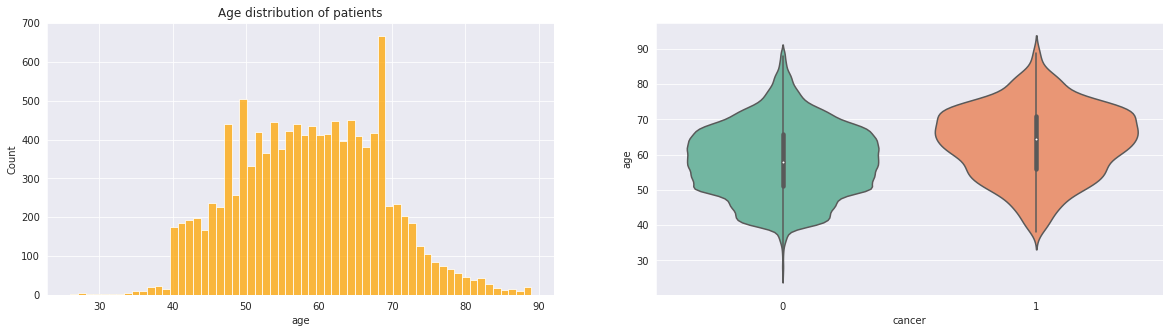

In [10]:
ages = train[train.age.isnull() == False].groupby(
    'patient_id').age.apply(lambda l: np.unique(l)[0])

fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.histplot(ages, color='orange', bins=60, ax=ax[0])
ax[0].set_title('Age distribution of patients');
sns.violinplot(train.cancer, train.age, ax=ax[1], palette='Set2');

### Insights

* Most of the patients are older than 40 years. 
* It seems that we have two peaks around the age of 50 and close to 70. 
* There is a drop of patients counts after the age of 70. 
* For patients with cancer it's more likely that they are older and above the age of 50. 

How many patients do have cancer and how many images were taken per patient?

In [11]:
def has_cancer(l):
    if len(l) == 1:
        if l[0] == 0:
            return False
        elif l[0] == 1:
            return True
        else:
            raise Exception
    elif len(l) == 2:
        return True
    else:
        raise Exception

patient_cancer_map = train.groupby('patient_id').cancer.unique().apply(lambda l: has_cancer(l))

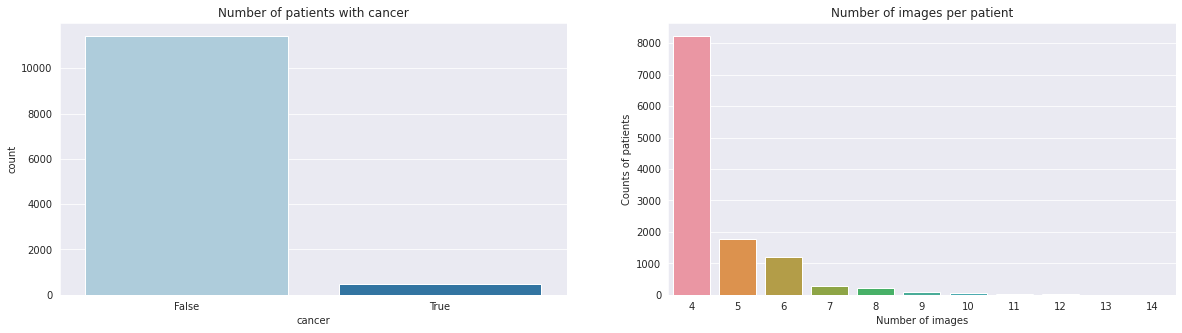

In [12]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(patient_cancer_map, palette='Paired', ax=ax[0]);
ax[0].set_title('Number of patients with cancer');

sns.countplot(train.groupby('patient_id').size(), ax=ax[1])
ax[1].set_title('Number of images per patient')
ax[1].set_xlabel('Number of images')
ax[1].set_ylabel('Counts of patients');

### Insights

* It's an imbalanced classification problem! 
* In most cases we have given 4 images per patient but there are a few cases with more than 10 images as well! Why?

## Image features <a class="anchor" id="image_features"></a>

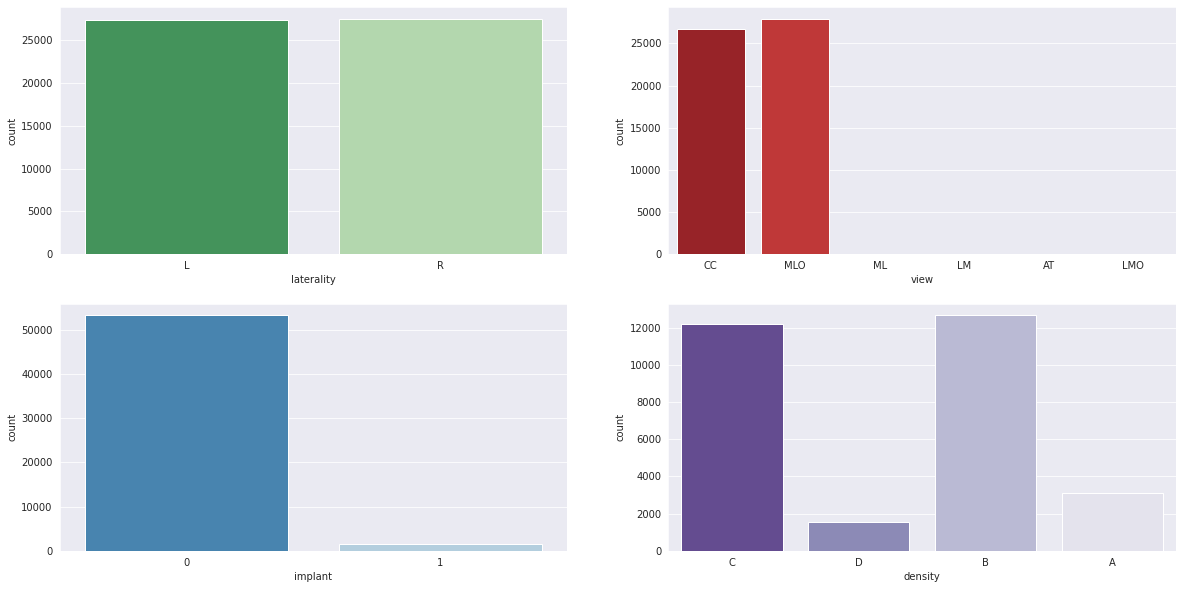

In [13]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.countplot(train.laterality, ax=ax[0,0], palette='Greens_r')
sns.countplot(train.view, ax=ax[0,1], palette='Reds_r')
sns.countplot(train.implant, ax=ax[1,0], palette='Blues_r')
sns.countplot(train.density, ax=ax[1,1], palette='Purples_r');

### Insights

* The laterality is quite balanced. 
* In the data description we can find that there are usually two views per breast. The most common views are CC and MLO and given these 2 views for the right and left breast we end up with 4 images that most of the patients show.  
* Only a very few images show implants. 
* Most of the images show medium dense images of category B and C. Nonetheless there are also cases that are very dense (D) or less dense (A). Given the information that it could be more difficult to identify cancer in dense tissues this could be an interesting feature when thinking about validation strategies. 

## Inspecting target features <a class="anchor" id="target_features"></a>

We have already seen that the number of patients with cancer is quiet low compared to the patients without. Let's see how it looks like on the image-level.

In [14]:
biopsy_counts = train.groupby('cancer').biopsy.value_counts().unstack().fillna(0) 
biopsy_perc = biopsy_counts.transpose() / biopsy_counts.sum(axis=1)

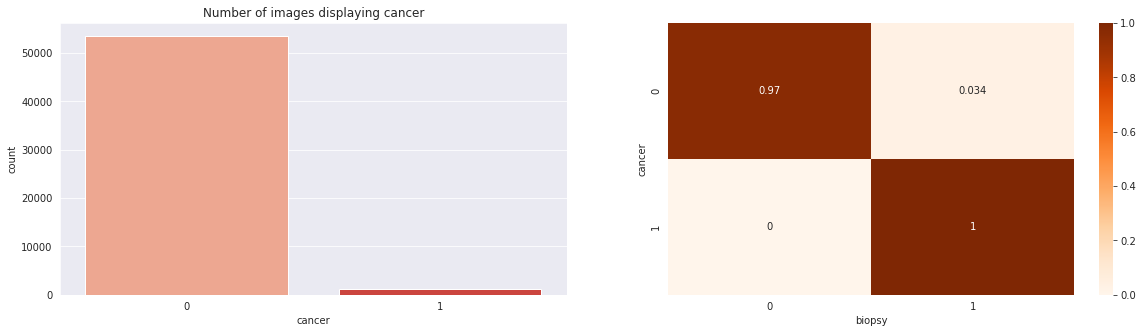

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train.cancer, palette='Reds', ax=ax[0])
ax[0].set_title('Number of images displaying cancer');
sns.heatmap(biopsy_perc.transpose(), ax=ax[1], annot=True, cmap='Oranges');

### Insights

* The number of images displaying cancer is very low. It should be even of lower percentage than the number of patients with cancer. 
* Looking at the biopsy feature we can say that all patients with cancer had a biopsy. But only around 3 % of images without cancer had resulted in a follow-up biopsy. Maybe we should better have a look at this feature on the patient-level. 

In [16]:
train.cancer.value_counts()/train.shape[0]

0    0.978832
1    0.021168
Name: cancer, dtype: float64

In [17]:
patient_cancer_map.value_counts() / patient_cancer_map.shape[0]

False    0.959204
True     0.040796
Name: cancer, dtype: float64

As expected, the percentage of patients with cancer is higher than the percentage of images displaying cancer. How many images show invasive cancer that has spread beyond the layer of tissue in which it developed?

<AxesSubplot:xlabel='BIRADS', ylabel='count'>

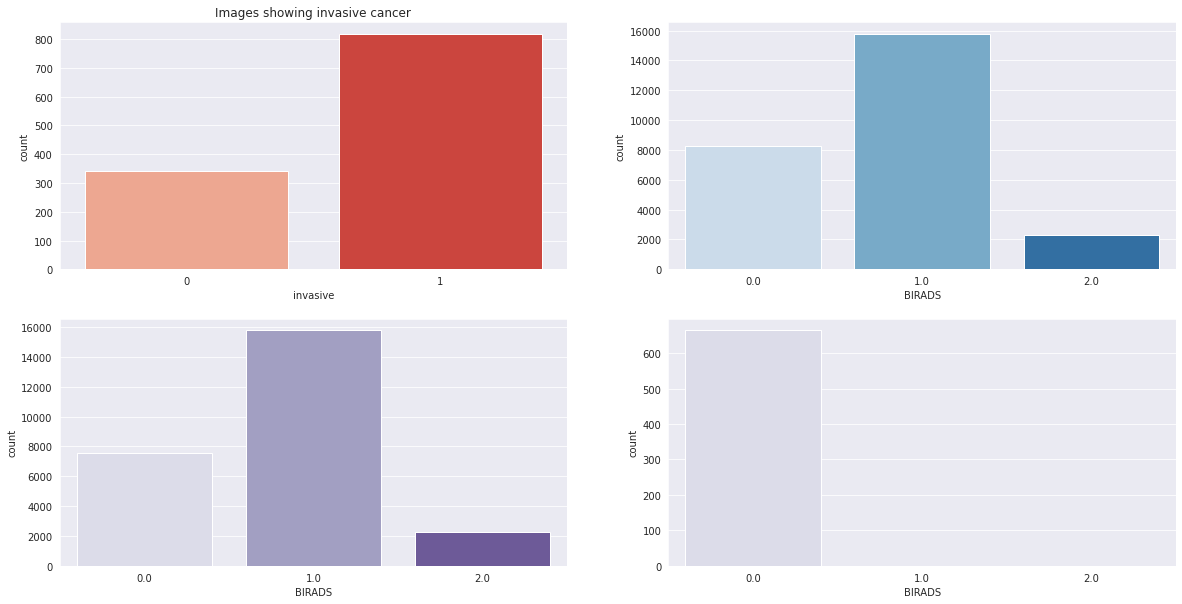

In [18]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.countplot(train[train.cancer==1].invasive, ax=ax[0,0], palette='Reds')
sns.countplot(train.BIRADS, order=[0., 1., 2.], ax=ax[0,1], palette='Blues')
ax[0,0].set_title('Images showing invasive cancer');

sns.countplot(train[train.cancer==0].BIRADS, order=[0., 1., 2.], ax=ax[1,0], palette='Purples')
sns.countplot(train[train.cancer==1].BIRADS, order=[0., 1., 2.], ax=ax[1,1], palette='Purples')

In [19]:
train[train.cancer==1].invasive.value_counts() / train[train.cancer==1].shape[0]

1    0.70639
0    0.29361
Name: invasive, dtype: float64

### Insights

* Roughly 70 % of all images displaying cancer are showing invasive cancer thus the one that spreads into other tissues as well. :(
* For BIRADS we need to remember that its value is
    * 0 if the breast required follow-up
    * 1 if the breast was rated as negative for cancer 
    * 2 if the breast was rated as normal
* Given that information, we can see that most images were rated as negative which suites to the fact that most images are not positive for cancer. But nonetheless there is still a high number of images that lead into a follow-up. I'm a bit confused... what's the difference between 1 and 2? From the ordering I would suspect that 2 is better than 1. 
* Going one level deeper and showing the BIRADS counts for 'no cancer'-images and 'cancer'-images, we can at least say that all images showing cancer needed a follow up (what we expected! ;))

## Machine Ids <a class="anchor" id="machine_ids"></a>

How many different imaging devices were used?

In [20]:
train.machine_id.nunique()

10

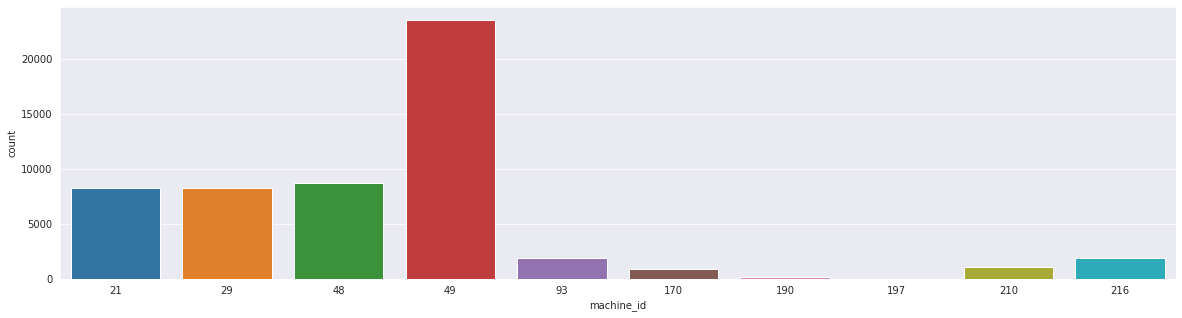

In [21]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(train.machine_id, palette='tab10', ax=ax);

### Insights

* 10 different machines but most of the images were take with device of id 49, 21, 29 and 48. 
* Personally I'm not sure whether this feature has some importance for us. To be honest, I think that the patient_id, the age and the density will be much more important than the machine. 

# Exploring the images <a class="anchor" id="images"></a>

Browsing through the train and test folder of the images, we can see that the data is given as dicom files. Long time ago I wrote a tutorial notebook on dicom files while I was learning more about it myself. Please take a look at it if dicom is unknown to you. I hope that it will help to get started with the data structure. ;) 

https://www.kaggle.com/code/allunia/pulmonary-dicom-preprocessing


In [22]:
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/'
test_path = '/kaggle/input/rsna-breast-cancer-detection/test_images/'

First of all, we need a method to get all scans of one patient:

In [23]:
def load_scans(path, patient_id):
    dcm_path = path + str(patient_id)
    slices = [pydicom.dcmread(dcm_path + '/' + file, force=True) for file in listdir(dcm_path)]
    return slices

## Pixelarray distributions <a class="anchor" id="raw values"></a>

* Usually we need to transform the raw pixelarray distributions to Hounsfield Units. The raw values depend on the measurement settings like acquisition parameters and tube voltage of the scanner. 
* By normalizing to values of water and air (water has HU 0 and air -1000) the images of different measurements are becoming comparable. 
* We also need to understand how background values were treated! In previous competitions it was often the case that background values were set to values smaller than -1000, but we need to check whether this was done in this competition as well!

Let's load an example:

In [24]:
patient_ids = train.patient_id.unique()

In [25]:
scans = load_scans(train_path, patient_ids[0])

And let's plot the raw pixelarray distribution for this example and display the related image:

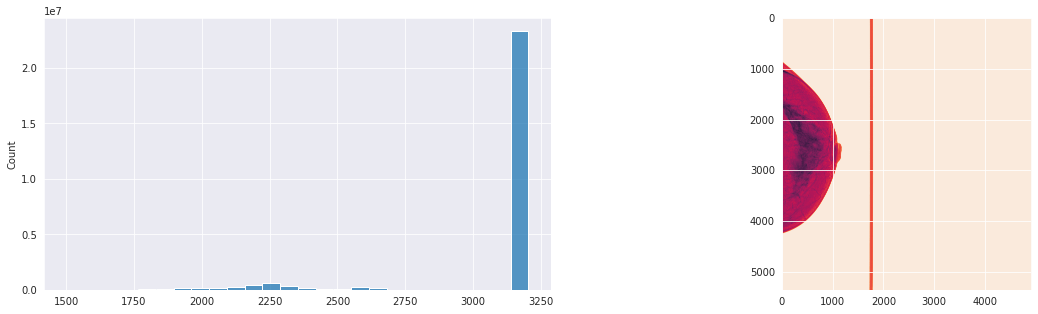

In [26]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(scans[0].pixel_array.flatten(), ax=ax[0])
ax[1].imshow(scans[0].pixel_array)

### Insights

* Uhh! That's interesting! The background seems to be above 3000 this time! So it's competely different to previous competitions.
* As the raw values depend on the machine, it could be worth it to explore background values dependent on the machine id. 

Let's get an impression by extracting the mode per scan for a few patients (let's say 50) for each machine id.

In [27]:
machine_ids = train.machine_id.unique()
machine_ids

array([ 29,  21, 216,  93,  49,  48, 170, 210, 190, 197])

In [28]:
scans[0].Columns

4915

## Background values and image sizes <a class="anchor" id="mid_dependence"></a>

In [29]:
background_values = []
rows = []
columns = []
for mid in train.machine_id.unique():
    mid_background_values = []
    mid_rows = []
    mid_columns = []
    print(f'machine id {mid} in progress')
    for n in range(50):
        try:
            scans = load_scans(train_path, train[train.machine_id==mid].patient_id.unique()[n])
            mid_background_values.append(mode(scans[0].pixel_array.flatten())[0][0])
            mid_rows.append(scans[0].Rows)
            mid_columns.append(scans[0].Columns)
        except IndexError:
            break
    background_values.append(mid_background_values)
    rows.append(mid_rows)
    columns.append(mid_columns)

machine id 29 in progress
machine id 21 in progress
machine id 216 in progress
machine id 93 in progress
machine id 49 in progress
machine id 48 in progress
machine id 170 in progress
machine id 210 in progress
machine id 190 in progress
machine id 197 in progress


In [30]:
for n in range(len(background_values)):
    print(machine_ids[n], np.median(background_values[n]), np.std(background_values[n]))

29 3524.0 215.81028705786943
21 0.0 0.0
216 0.0 146.7420539586386
93 0.0 289.45188477534566
49 0.0 0.0
48 0.0 0.0
170 0.0 0.0
210 1017.0 2.2293496809607953
190 0.0 67.79807427332629
197 83.5 219.29090268408308


### Insights

* It depends on the machine id, how background values are treated. In most of the cases they seem to be 0. But for id 29 it's above 3000 and for id 210 it seems to be 1017. 
* Id 197 looks interesting. Currently I don't know, what it means. Let's take a look at the values

In [31]:
background_values[-1]

[0, 537, 0, 167]

Ah, ok, only 4 patients and it could be that the background values for patient 2 and 4 are not the same as the mode.

What about the image sizes? Are they also dependent on the machine id? Let's have a look at the columns and the rows:

In [32]:
for l in range(len(columns)):
    print(f"machine id {train.machine_id.unique()[l]}, unique columns: {np.unique(columns[l])}")

machine id 29, unique columns: [4915]
machine id 21, unique columns: [2082]
machine id 216, unique columns: [1914]
machine id 93, unique columns: [1914 2394]
machine id 49, unique columns: [2560 3328]
machine id 48, unique columns: [3328]
machine id 170, unique columns: [2560 3328]
machine id 210, unique columns: [3540 4728]
machine id 190, unique columns: [1914 2394]
machine id 197, unique columns: [1022 1914 2045 2394]


In [33]:
for l in range(len(rows)):
    print(f"machine id {train.machine_id.unique()[l]}, unique rows: {np.unique(rows[l])}")

machine id 29, unique rows: [5355]
machine id 21, unique rows: [2776]
machine id 216, unique rows: [2294]
machine id 93, unique rows: [2294 3062]
machine id 49, unique rows: [3328 4096]
machine id 48, unique rows: [4096]
machine id 170, unique rows: [3328 4096]
machine id 210, unique rows: [4740 5928]
machine id 190, unique rows: [2294 3062]
machine id 197, unique rows: [1236 2294 2473 2850]


IHH! :-o The image size depends on the machine id as well! Ohoh! What else will depend on it? ... Time to take a look at a single dicom file to search for further features:

In [34]:
mid = train.machine_id.value_counts().index.values[8]
mid

190

In [35]:
mid_patients = train[train.machine_id == mid].patient_id.unique()
scans = load_scans(train_path, mid_patients[0])
scans[0]

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10577.1.265773887
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10577.1.265773887
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183929.264891'
(0010, 0020) Patient ID                          LO: '10577'
(0018, 11a0) Body Part Thickness                 DS: '71.0'
(001

What else could be interesting or worth it to explore? After browsing through some examples per mid, I found a few more interesting features that might be relevant or interesting to understand:


* Body Part Thickness (what's that?) - not always present
* Compression Force (what's that?) - not always present
* Pixel Spacing - not always present
* Pixel Padding Value (often 0, but not always & sometimes not given)
* Photometric Interpretation: Changes sometimes
* Pixel Intensity Relationship Sign (seems to be 1 or -1)
* window width and window center (do we need that?)

### Insights

* The sizes of the dicom images as well as the background values depend on the machine id.
* Besides that there are further features that may also have this dependency but we don't know it yet. We have to investigate this even further.
* We also found a few machine ids that have some variability inside their group (like images with two different sizes or a few possible background values).

One idea could be to do preprocessing of dicom files dependent on the machine id or another idea could be to explore this structure even further and to uncover all different patterns we can find in train... hmm :-)

## Exploring dicom images of machine 49 <a class="anchor" id="mid_49"></a>

Let's keep it simple for now by making the assumption that all files with the same machine id share similar or same features. Then we could try to explore more (probably visual) patterns within one machine id group. The largest one belongs to id 49. 

In [36]:
train[train.machine_id==49].shape

(23529, 14)

In [37]:
train[train.machine_id==49].patient_id.nunique()

4589

4589 patients in that group! Maybe it's sufficient to explore the images given a resized and transformed dataset like that one of Theo Viel with png-images of size 256x256:

* https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-256-pngs

In [38]:
train['png_256_path'] = "/kaggle/input/rsna-breast-cancer-256-pngs/" + train.patient_id.astype(str) + "_" + train.image_id.astype(str) + ".png"

In [39]:
means = []
medians = []
stds = []
skews = []
paths = []
targets = []

patients_49 = train[train.machine_id==49].patient_id.unique()

for n in range(len(patients_49)):
    pid = patients_49[n]
    path = train[(train.machine_id==49) & (train.patient_id==pid)].png_256_path.values[0]
    targets = train[(train.machine_id==49) & (train.patient_id==pid)].cancer.values[0]
    paths.append(path)
    image = Image.open(path)
    means.append(np.mean(image))
    medians.append(np.median(image))
    stds.append(np.std(image))
    skews.append(skew(image, axis=None))

In [40]:
stats_49 = pd.DataFrame(means, index=patients_49, columns =["means"])
stats_49['stds'] = stds
stats_49['medians'] = medians
stats_49['skews'] = skews
stats_49['paths'] = paths
stats_49['cancer'] = targets 

In [41]:
fig = px.scatter_3d(stats_49, x='means', y='stds', z='skews',
              color='medians')
fig.show()

### Insights

* Given the image statistics I would say that there are at least four groups. 
* One group has large median values, small stds, high mean values and low skewness. 
* Second groupd is very dense with low means and stds but low to high skewnesses. 
* The thrid group shows high mean values and stds, but low skewness. 
* The last group has low values for all features.

Let's cluster that a bit to explore different visual patterns:

In [42]:
scaler = StandardScaler()
X = stats_49.drop(['paths', 'cancer'], axis=1).values
X = scaler.fit_transform(X)

In [43]:
gmm = GaussianMixture(n_components=4, random_state=0)
stats_49["cluster_label"] = gmm.fit_predict(X)

In [44]:
fig = px.scatter_3d(stats_49, x='means', y='stds', z='skews',
              color='cluster_label')
fig.show()

Ok let's take a look at the different images per cluster label:

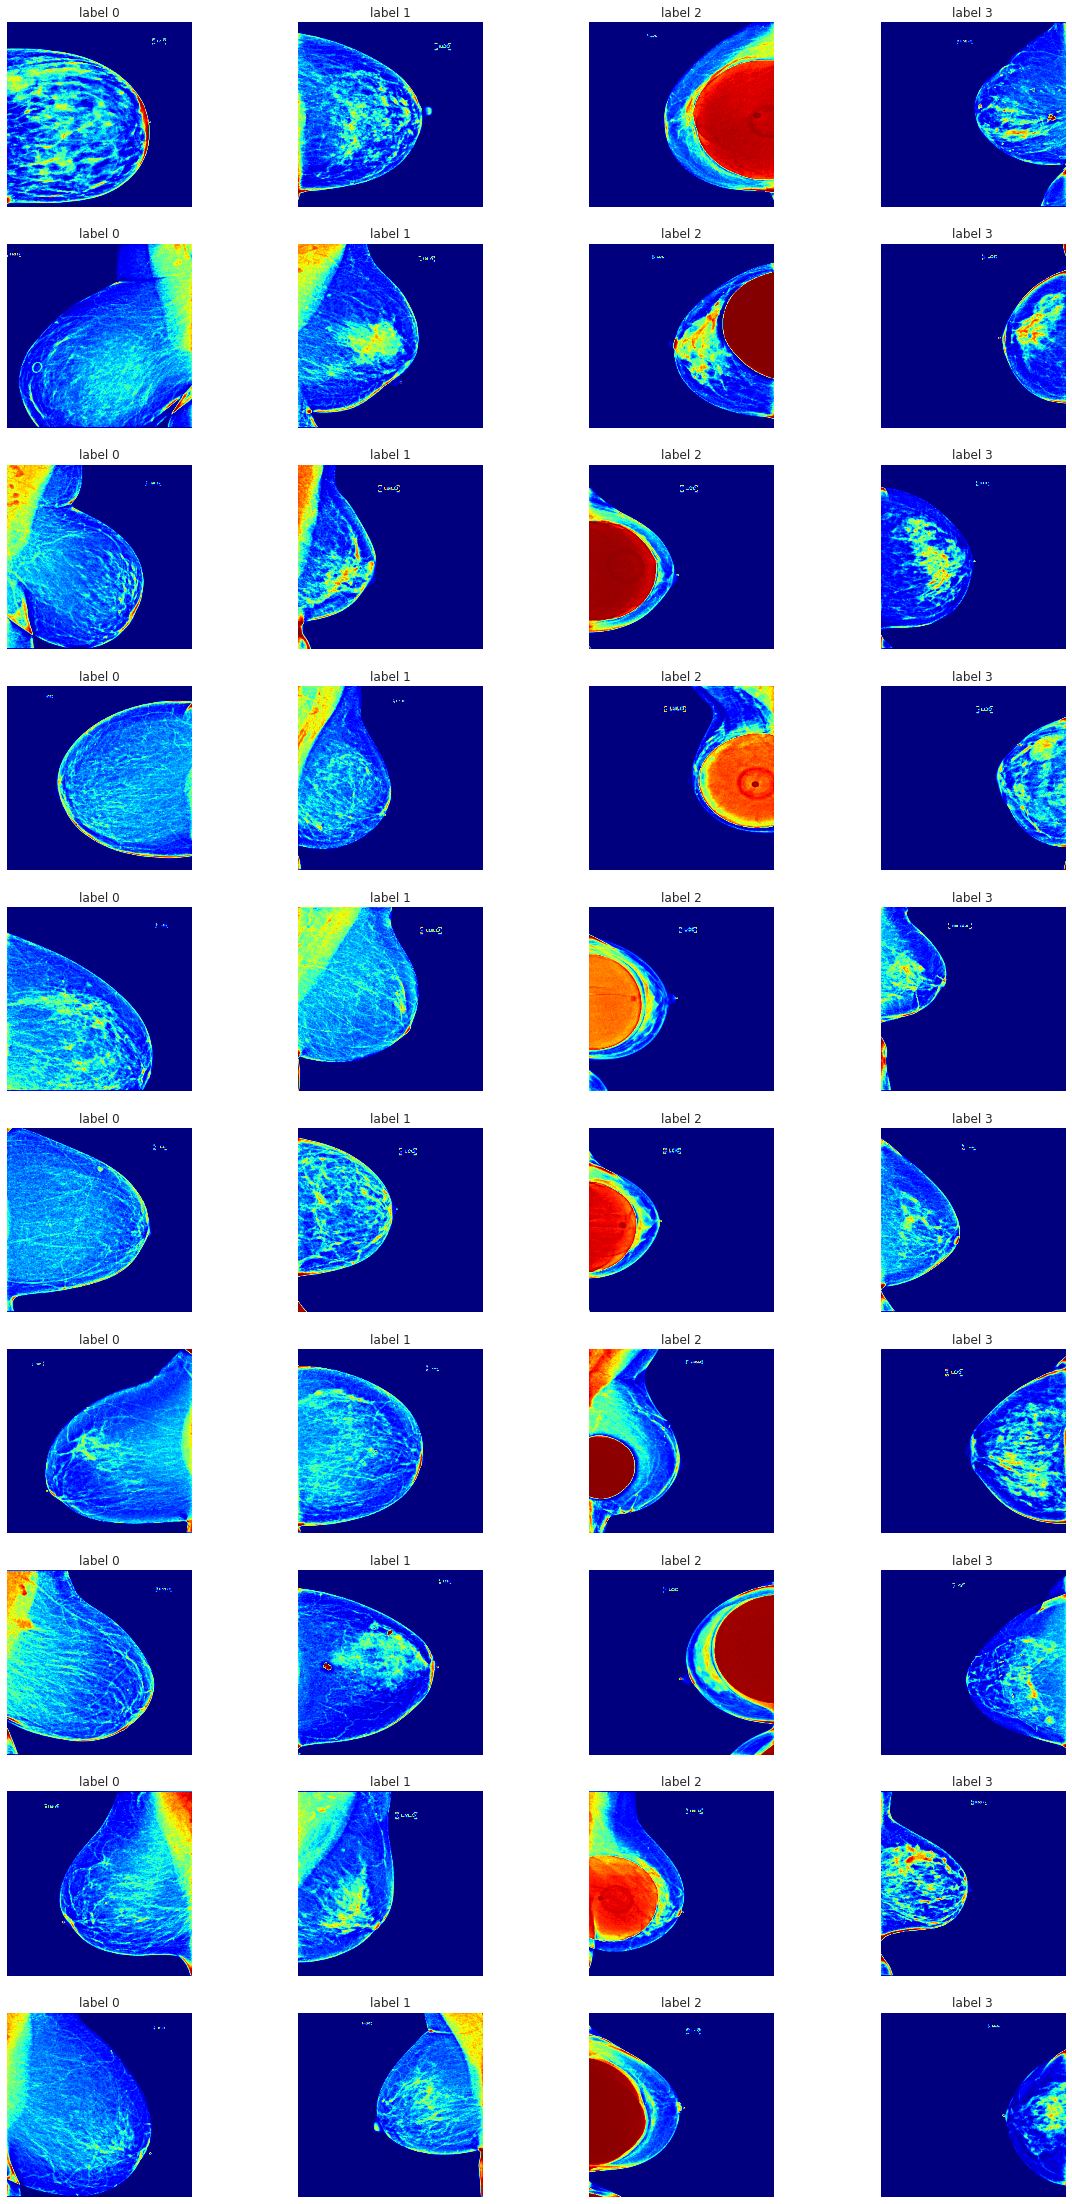

In [45]:
fig, ax = plt.subplots(10,4,figsize=(20,40))
for l in range(4):
    img_paths = stats_49[stats_49.cluster_label==l].paths.values[0:10]
    for n in range(10):
        try:
            image = Image.open(img_paths[n])
            ax[n,l].imshow(image, cmap='jet')
            ax[n,l].set_title(f"label {l}")
        except:
            continue
        ax[n,l].axis('off')

In [46]:
np.unique(stats_49.cancer)

array([0])

### Insights

* The group with high median values stands out most. We can see that there are large regions within the breast with high intensity values. And it's not cancer!
* In contrast the other images vary mainly in the amount of background values and still look very similar. 

In [47]:
high_intensity_patients = stats_49[stats_49.cluster_label==2].index.values

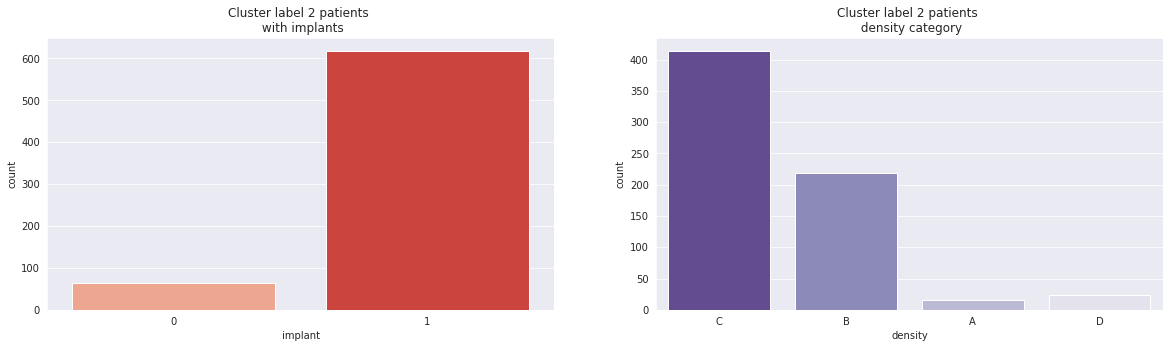

In [48]:
selection = train[train.patient_id.isin(high_intensity_patients)]


fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(selection.implant, ax=ax[0], palette='Reds')
sns.countplot(selection.density, ax=ax[1], palette='Purples_r')
ax[0].set_title('Cluster label 2 patients \n with implants');
ax[1].set_title('Cluster label 2 patients \n density category');

Ahh! Most of these images show implants! :-)

In [49]:
train[train.implant==1].difficult_negative_case.value_counts() / train[train.implant==1].shape[0]

False    0.815166
True     0.184834
Name: difficult_negative_case, dtype: float64

In [50]:
train[train.implant==0].difficult_negative_case.value_counts() / train[train.implant==0].shape[0]

False    0.860377
True     0.139623
Name: difficult_negative_case, dtype: float64

Hmm, I'm not sure if this is just noise. 

## Exploring some outliers of machine 49 <a class="anchor" id="outliers"></a>

In [51]:
stats_49['logL'] = gmm.score_samples(X)

In [52]:
stats_49.logL.quantile(q=0.01)

-8.355624556481349

In [53]:
outliers = stats_49[stats_49.logL < -10].sort_values(by='logL')
len(outliers)

32

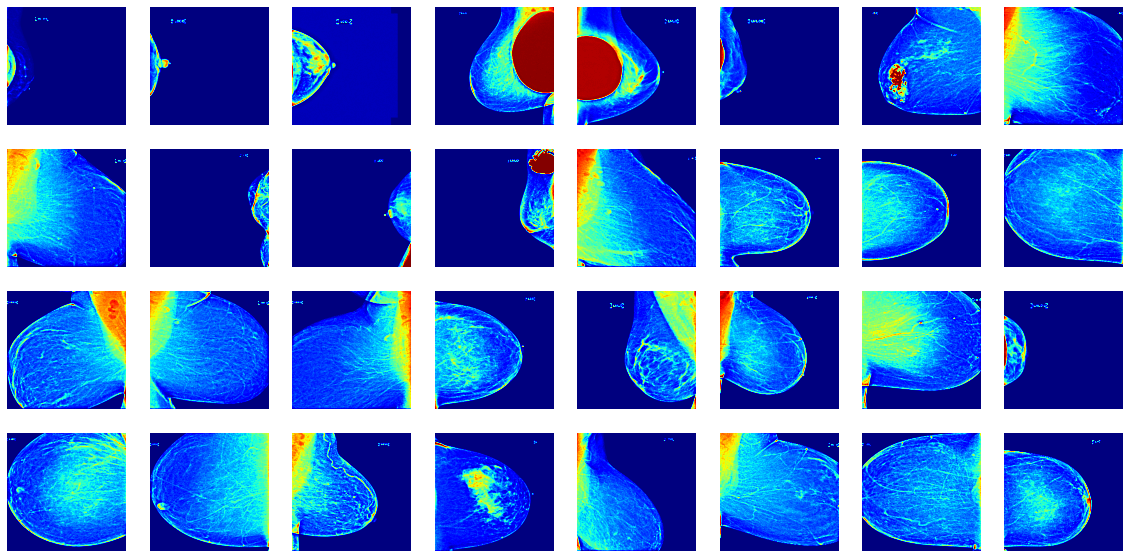

In [54]:
fig, ax = plt.subplots(4,8, figsize=(20,10))
for n in range(4):
    for m in range(8):
        image = Image.open(outliers.paths.values[8*n+m])
        ax[n,m].imshow(image, cmap='jet')
        ax[n,m].axis('off')

Ah, ok! We should expect both - cases with the whole image covered with breast and images with almost no tissue at all. Furthermore we will have some cases with some kind of artifacts like the thrid one in the first row that shows different background values separated by a sharp edge. Most likely there will be other outliers as well that we will not be able to find with the simple method of using image statistics. 

## Exploring images with cancer <a class="anchor" id="cancer"></a>

Last but not least I would like to explore some dicom images with cancer and to ensure that dicom files are similar I will continue with machine id 49. 

In [55]:
selection = train[(train.machine_id==49) & (train.cancer==1)]

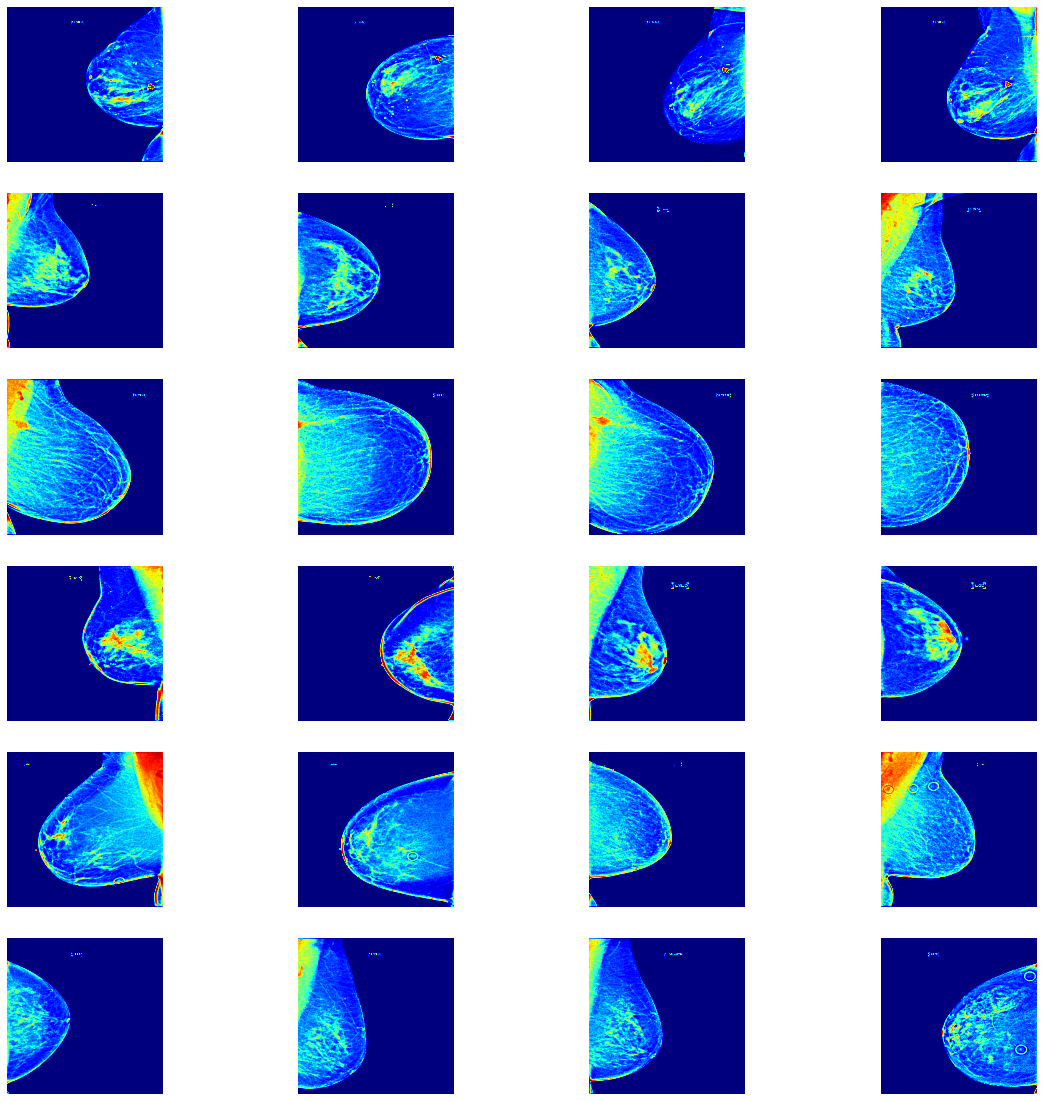

In [56]:
N = 4
M = 6
fig, ax = plt.subplots(M,N,figsize=(20,20))
for m in range(M):
    for n in range(N):
        image = Image.open(selection.png_256_path.values[N*m+n])
        ax[m,n].imshow(image, cmap='jet')
        ax[m,n].axis("off")

Hmm, difficult! I can't really say that I see a difference to those above.

# Conclusion <a class="anchor" id="conclusion"></a>

My simplified data exploration has come to an end. What have I found so far?

* We are asked to solve an imbalanced classification problem with only ~ 2% of images showing cancer. 
* For patients with cancer it's more likely that they are already very old.
* Most of the patients have 4 images with left and right breast in combination with the two default views CC and MLO. But there are a few exceptions from this rule with more images and more views. 
* How the raw dicom pixelarray values need to be preprocessed depends on the machine id! Background values were treated differently and it seems that are more relevant dicom features we should try to understand before generating a png/jpeg dataset. 
* Most images (~70%) with cancer are showing invasive cancer. 
* The image sizes depend on the machine id as well!
* The clustering of image statistics has shown that implants show high intensity values and that we should expect artifacts and different levels of tissue covering the image area. 


How would I like to continue?

* First of all, I would try to find a good way to preprocess the raw dicom pixelarray values given the machine id (or better features that can be found in the dicom file as they will be availabe for test data as well). 
* Then I would think about strategies for validation and I think some of the findings above could be interesting to take into account.
